## CESM2 - LARGE ENSEMBLE (LENS2)

#### by Mauricio Rocha and Dr. Gustavo Marques

 - This Notebook is intended to find maxima or minima of the MOC in certain latitude ranges. 

In [1]:
import xarray as xr 
import pandas as pd
import numpy as np  
import dask
import cf_xarray
import intake
import cftime
import nc_time_axis
import intake_esm
import matplotlib.pyplot as plt
import pop_tools
from dask.distributed import Client
from ncar_jobqueue import NCARCluster

## Improve the workflow using clusters 

In [2]:
mem_per_worker = 3 # in GB 
num_workers = 60 
cluster = NCARCluster(cores=1, processes=3, memory=f'{mem_per_worker} GB',resource_spec=f'select=1:ncpus=6:mem={mem_per_worker}GB')
cluster.scale(num_workers)
client = Client(cluster)
print(client)
client

<Client: 'tcp://10.12.206.56:41145' processes=0 threads=0, memory=0 B>


Connection method: Cluster object,Cluster type: dask_jobqueue.PBSCluster
Dashboard: https://jupyterhub.hpc.ucar.edu/stable/user/mauricio/mrocha/proxy/8787/status,
Dashboard: https://jupyterhub.hpc.ucar.edu/stable/user/mauricio/mrocha/proxy/8787/status,Workers: 0
Total threads: 0,Total memory: 0 B
Comm: tcp://10.12.206.56:41145,Workers: 0
Dashboard: https://jupyterhub.hpc.ucar.edu/stable/user/mauricio/mrocha/proxy/8787/status,Total threads: 0
Started: Just now,Total memory: 0 B


### Read in OGCM history file & MOC template file

In [3]:
catalog = intake.open_esm_datastore(
    '/glade/collections/cmip/catalog/intake-esm-datastore/catalogs/glade-cesm2-le.json'
)

/glade/u/home/mauricio/.local/lib/python3.8/site-packages/intake_esm/utils.py:96: DtypeWarning: Columns (5,6,9) have mixed types. Specify dtype option on import or set low_memory=False.
  return pd.read_csv(catalog_path, **csv_kwargs), catalog_path


In [4]:
cat_subset = catalog.search(component='ocn',variable=['MOC'],frequency='month_1',experiment="historical")
del catalog

In [5]:
# Load catalog entries for subset into a dictionary of xarray datasets
dset_dict_raw  = cat_subset.to_dataset_dict(zarr_kwargs={"consolidated": True}, storage_options={"anon": True})
print(f"\nDataset dictionary keys:\n {dset_dict_raw.keys()}")
del cat_subset


--> The keys in the returned dictionary of datasets are constructed as follows:
	'component.experiment.stream.forcing_variant.variable'



Dataset dictionary keys:
 dict_keys(['ocn.historical.pop.h.cmip6.MOC', 'ocn.historical.pop.h.smbb.MOC'])


In [6]:
%%time
fb=('smbb','cmip6')
for ifb in range(0,2):  
    print(f"Forcing_variant: {ifb}")
    str=f'ds_{fb[ifb]}_moc = dset_dict_raw[\'ocn.historical.pop.h.{fb[ifb]}.MOC\']' 
    exec(str)
    str=f'ds_{fb[ifb]}_moc = ds_{fb[ifb]}_moc.sel(time=slice(\'1850-01-01\', \'2015-12-31\'))' # Time Series
    exec(str)
    str=f'ds_{fb[ifb]}_moc = ds_{fb[ifb]}_moc.resample(time=\'1Y\', closed=\'left\').mean(\'time\')' # Yearly average
    exec(str)
    str=f'moc_{fb[ifb]} = ds_{fb[ifb]}_moc[\'MOC\']' # Variable
    exec(str)
    str=f'del ds_{fb[ifb]}_moc'
    exec(str)

Forcing_variant: 0
Forcing_variant: 1
CPU times: user 8.58 s, sys: 49.8 ms, total: 8.63 s
Wall time: 8.96 s


In [7]:
%%time
for ifb in range(0,2): 
    print(f"Forcing_variant: {ifb}")
    str=f'moc_{fb[ifb]}[\'moc_z\'] = -0.01*moc_{fb[ifb]}.moc_z' # cm to m and negative depth
    print(str)
    exec(str) 
    str=f'zz_{fb[ifb]}, yy_{fb[ifb]} = np.meshgrid(moc_{fb[ifb]}.moc_z, moc_{fb[ifb]}.lat_aux_grid)'
    print(str)
    exec(str) 
    str=f'zz_{fb[ifb]}=(np.array([zz_{fb[ifb]}]*len(moc_{fb[ifb]}[\'member_id\']))).transpose(0,2,1)'
    print(str)
    exec(str)
    str=f'yy_{fb[ifb]}=(np.array([yy_{fb[ifb]}]*len(moc_{fb[ifb]}[\'member_id\']))).transpose(0,2,1)'
    print(str)
    exec(str)

Forcing_variant: 0
moc_smbb['moc_z'] = -0.01*moc_smbb.moc_z
zz_smbb, yy_smbb = np.meshgrid(moc_smbb.moc_z, moc_smbb.lat_aux_grid)
zz_smbb=(np.array([zz_smbb]*len(moc_smbb['member_id']))).transpose(0,2,1)
yy_smbb=(np.array([yy_smbb]*len(moc_smbb['member_id']))).transpose(0,2,1)
Forcing_variant: 1
moc_cmip6['moc_z'] = -0.01*moc_cmip6.moc_z
zz_cmip6, yy_cmip6 = np.meshgrid(moc_cmip6.moc_z, moc_cmip6.lat_aux_grid)
zz_cmip6=(np.array([zz_cmip6]*len(moc_cmip6['member_id']))).transpose(0,2,1)
yy_cmip6=(np.array([yy_cmip6]*len(moc_cmip6['member_id']))).transpose(0,2,1)
CPU times: user 7.53 ms, sys: 3.98 ms, total: 11.5 ms
Wall time: 14.2 ms


In [8]:
matrix = np.empty((len(moc_smbb['time']),len(moc_smbb['member_id']),2,3)) * np.nan

/glade/scratch/mauricio/ipykernel_217546/1230445006.py:1: RuntimeWarning: invalid value encountered in multiply
  matrix = np.empty((len(moc_smbb['time']),len(moc_smbb['member_id']),2,3)) * np.nan


In [9]:
matrix.shape

(166, 50, 2, 3)

In [10]:
%%time
for ifb in range(0,2): # forcing variant (smbb=0, cmip6=1)
    print(f"Forcing_variant: {ifb}")
    for it in range(0,len(moc_smbb['time'])): # time (56 years from 1960 to 2015)
        print(f"Time: {it}")
        
        # Maximum AMOC for the North Atlantic
        str=f'''amoc = moc_{fb[ifb]}.isel(time=it,transport_reg=1,moc_comp=0).where(
        (moc_{fb[ifb]}.isel(time=it,transport_reg=1,moc_comp=0)['moc_z'] > -3500) & 
        (moc_{fb[ifb]}.isel(time=it,transport_reg=1,moc_comp=0)['lat_aux_grid'] > 0) &
        (moc_{fb[ifb]}.isel(time=it,transport_reg=1,moc_comp=0)['lat_aux_grid'] < 70),
        drop=True
        )'''
        exec(str)
        str=f'matrix[it,:,ifb,0]=amoc.max(dim=[\'moc_z\',\'lat_aux_grid\'])' 
        exec(str)
        
        # Maximum AMOC for the South Atlantic
        str=f'''amoc = moc_{fb[ifb]}.isel(time=it,transport_reg=1,moc_comp=0).where(
        (moc_{fb[ifb]}.isel(time=it,transport_reg=1,moc_comp=0)['moc_z'] > -3500) & 
        (moc_{fb[ifb]}.isel(time=it,transport_reg=1,moc_comp=0)['lat_aux_grid'] > -70) &
        (moc_{fb[ifb]}.isel(time=it,transport_reg=1,moc_comp=0)['lat_aux_grid'] < 0),
        drop=True
        )'''
        exec(str)
        str=f'matrix[it,:,ifb,1]=amoc.max(dim=[\'moc_z\',\'lat_aux_grid\'])' 
        exec(str)
        
        # Minimum AMOC for the South Atlantic
        str=f'''amoc = moc_{fb[ifb]}.isel(time=it,transport_reg=1,moc_comp=0).where(
        (moc_{fb[ifb]}.isel(time=it,transport_reg=1,moc_comp=0)['moc_z'] > -3500) & 
        (moc_{fb[ifb]}.isel(time=it,transport_reg=1,moc_comp=0)['lat_aux_grid'] > -70) &
        (moc_{fb[ifb]}.isel(time=it,transport_reg=1,moc_comp=0)['lat_aux_grid'] < 0),
        drop=True
        )'''
        exec(str)
        str=f'matrix[it,:,ifb,2]=amoc.min(dim=[\'moc_z\',\'lat_aux_grid\'])' 
        exec(str)
        del amoc

Forcing_variant: 0
Time: 0
Time: 1
Time: 2
Time: 3
Time: 4
Time: 5
Time: 6
Time: 7
Time: 8
Time: 9
Time: 10
Time: 11
Time: 12
Time: 13
Time: 14
Time: 15
Time: 16
Time: 17
Time: 18
Time: 19
Time: 20
Time: 21
Time: 22
Time: 23
Time: 24
Time: 25
Time: 26
Time: 27
Time: 28
Time: 29
Time: 30
Time: 31
Time: 32
Time: 33
Time: 34
Time: 35
Time: 36
Time: 37
Time: 38
Time: 39
Time: 40
Time: 41
Time: 42
Time: 43
Time: 44
Time: 45
Time: 46
Time: 47
Time: 48
Time: 49
Time: 50
Time: 51
Time: 52
Time: 53
Time: 54
Time: 55
Time: 56
Time: 57
Time: 58
Time: 59
Time: 60
Time: 61
Time: 62
Time: 63
Time: 64
Time: 65
Time: 66
Time: 67
Time: 68
Time: 69
Time: 70
Time: 71
Time: 72
Time: 73
Time: 74
Time: 75
Time: 76
Time: 77
Time: 78
Time: 79
Time: 80
Time: 81
Time: 82
Time: 83
Time: 84
Time: 85
Time: 86
Time: 87
Time: 88
Time: 89
Time: 90
Time: 91
Time: 92
Time: 93
Time: 94
Time: 95
Time: 96
Time: 97
Time: 98
Time: 99
Time: 100
Time: 101
Time: 102
Time: 103
Time: 104
Time: 105
Time: 106
Time: 107
Time: 108
T

In [11]:
matrix_moc = xr.Dataset({"MOC": (("time","member_id","forcing_variant","basin"), matrix)},
                 coords={
                     "time": moc_cmip6.coords['time'], 
                     "member_id": moc_cmip6.coords['member_id'],
                     "forcing_variant": ['smbb (0)','cmip6 (1)'],
                     "basin": ['North Atlantic Max (0)','South Atlantic Max (1)','South Atlantic Min (2)'],
                     "transport_reg": [1],
                     "moc_comp": [0],
                     "experiment": ['historical'],
                 },
                )

In [12]:
matrix_moc.to_netcdf('/glade/scratch/mauricio/data/tseries/amoc_historical_lens2.nc')

In [13]:
tempo=xr.cftime_range(start='1850', end='2016',periods=None, freq='A',normalize=False, name=None, closed=None, calendar='standard')

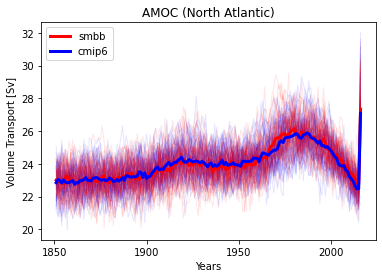

In [15]:
plt.close()
fig = plt.figure()
ax = plt.axes()
#ax.plot(tempo, matrix_moc.MOC.isel(basin=1, forcing_variant=0), 'r')
ax.plot(tempo, matrix_moc.MOC.isel(basin=0,forcing_variant=1), label='_Hidden', color='blue', linewidth=1, alpha=0.1)
ax.plot(tempo, matrix_moc.MOC.isel(basin=0,forcing_variant=0),label='_Hidden', color='red', linewidth=1, alpha=0.1)
ax.plot(tempo, matrix_moc.MOC.isel(basin=0,forcing_variant=0).mean('member_id'), label='smbb', color='red', linewidth=3)
ax.plot(tempo, matrix_moc.MOC.isel(basin=0,forcing_variant=1).mean('member_id'), label='cmip6', color='blue', linewidth=3)
plt.title("AMOC (North Atlantic)")
plt.xlabel("Years")
plt.ylabel("Volume Transport [Sv]")
plt.legend()

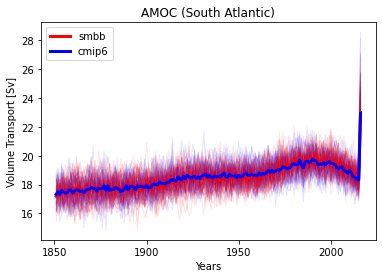

In [16]:
plt.close()
fig = plt.figure()
ax = plt.axes()
#ax.plot(tempo, matrix_moc.MOC.isel(basin=1, forcing_variant=0), 'r')
ax.plot(tempo, matrix_moc.MOC.isel(basin=1,forcing_variant=1), label='_Hidden', color='blue', linewidth=1, alpha=0.1)
ax.plot(tempo, matrix_moc.MOC.isel(basin=1,forcing_variant=0),label='_Hidden', color='red', linewidth=1, alpha=0.1)
ax.plot(tempo, matrix_moc.MOC.isel(basin=1,forcing_variant=0).mean('member_id'), label='smbb', color='red', linewidth=3)
ax.plot(tempo, matrix_moc.MOC.isel(basin=1,forcing_variant=1).mean('member_id'), label='cmip6', color='blue', linewidth=3)
plt.title("AMOC (South Atlantic)")
plt.xlabel("Years")
plt.ylabel("Volume Transport [Sv]")
plt.legend()

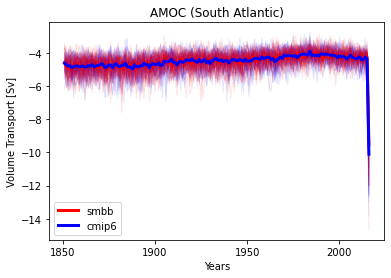

In [17]:
plt.close()
fig = plt.figure()
ax = plt.axes()
#ax.plot(tempo, matrix_moc.MOC.isel(basin=1, forcing_variant=0), 'r')
ax.plot(tempo, matrix_moc.MOC.isel(basin=2,forcing_variant=1), label='_Hidden', color='blue', linewidth=1, alpha=0.1)
ax.plot(tempo, matrix_moc.MOC.isel(basin=2,forcing_variant=0),label='_Hidden', color='red', linewidth=1, alpha=0.1)
ax.plot(tempo, matrix_moc.MOC.isel(basin=2,forcing_variant=0).mean('member_id'), label='smbb', color='red', linewidth=3)
ax.plot(tempo, matrix_moc.MOC.isel(basin=2,forcing_variant=1).mean('member_id'), label='cmip6', color='blue', linewidth=3)
plt.title("AMOC (South Atlantic)")
plt.xlabel("Years")
plt.ylabel("Volume Transport [Sv]")
plt.legend()